PyTorch 0.1.6 and torchvision 0.1.7 
https://github.com/rickiepark/pytorch-examples/blob/master/mnist.ipynb

In [1]:
%pylab
%matplotlib inline
%load_ext watermark
%watermark -v -p numpy,torch,torchvision

Using matplotlib backend: <object object at 0x10628f3e0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy      : 1.23.1
torch      : 2.1.1
torchvision: 0.16.1



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from loss_function import LogitNormLoss

In [3]:
class MnistClassifier(nn.Module):
    def __init__(self):
        super(MnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x) # F.log_softmax(x)
    
classifier = MnistClassifier()
classifier

MnistClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [4]:
batch_size = 50
train_subset, val_subset, cal_subset, test_subset = torch.utils.data.random_split(
        datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()), [30000, 10000, 10000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)

In [5]:
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
classifier.train()
train_loss = []
train_accu = []
i = 0
loss_func = LogitNormLoss('cpu', 0.1)
for epoch in range(1):
    for data, target in train_loader:
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = classifier(data)
        loss = loss_func(output, target) # F.nll_loss(output, target)
        loss.backward()    # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()   # update gradients
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
        train_accu.append(accuracy)
        if i % 100 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
        i += 1

Train Step: 0	Loss: 2.324	Accuracy: 14.000


/var/folders/x8/908frjt170d_bfpfjzgp163r0000gn/T/ipykernel_85695/158888622.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x) # F.log_softmax(x)


Train Step: 100	Loss: 0.437	Accuracy: 86.000
Train Step: 200	Loss: 0.328	Accuracy: 90.000
Train Step: 300	Loss: 0.301	Accuracy: 92.000
Train Step: 400	Loss: 0.090	Accuracy: 98.000
Train Step: 500	Loss: 0.314	Accuracy: 90.000


# Question: use the same training data to train the localizer, or another validation data?

/var/folders/x8/908frjt170d_bfpfjzgp163r0000gn/T/ipykernel_85695/158888622.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x) # F.log_softmax(x)


(array([ 101.,  689., 2648., 4670., 5723., 6779., 5665., 2739.,  855.,
         131.]),
 array([0.15050489, 0.23088902, 0.31127316, 0.39165729, 0.47204143,
        0.55242556, 0.6328097 , 0.71319383, 0.79357797, 0.8739621 ,
        0.95434624]),
 <BarContainer object of 10 artists>)

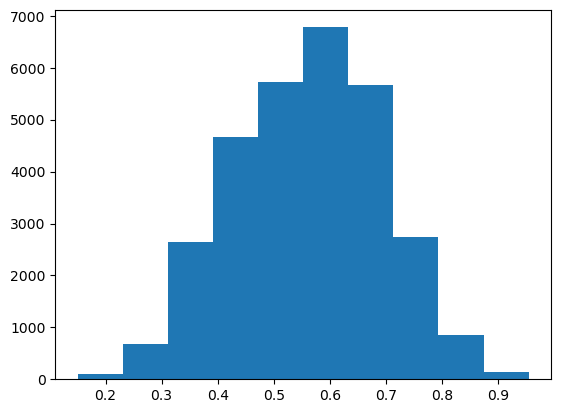

In [6]:
classifier.eval()
retrain_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=False, batch_size=len(train_subset.indices))
for data, target in retrain_loader:
    data, target = Variable(data), Variable(target)
    output = classifier(data)
    
# val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=len(val_subset.indices))
# for data, target in val_loader:
#     data, target = Variable(data), Variable(target)
#     output = classifier(data)

ER = 1 - output[np.arange(output.shape[0]), target]
plt.hist(ER.detach().numpy())

In [7]:
class MnistRegressor(nn.Module):
    def __init__(self):
        super(MnistRegressor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 1)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
regressor = MnistRegressor()
regressor

MnistRegressor(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [8]:
ER_train_data = []
for i in range(len(data)):
    ER_train_data.append([data[i], ER[i]])
ER_train_loader = torch.utils.data.DataLoader(ER_train_data, shuffle=True, batch_size=batch_size)

optimizer = optim.Adam(regressor.parameters(), lr=0.001)
regressor.train()
ER_train_loss = []

i = 0
for epoch in range(1):
    for data, target in ER_train_loader:
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = regressor(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        ER_train_loss.append(loss.data.item())
        optimizer.step()
        if i % 100 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.data.item()))
        i += 1

/var/folders/x8/908frjt170d_bfpfjzgp163r0000gn/T/ipykernel_85695/1160276927.py:16: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, target)


Train Step: 0	Loss: 0.339
Train Step: 100	Loss: 0.014
Train Step: 200	Loss: 0.022
Train Step: 300	Loss: 0.019
Train Step: 400	Loss: 0.024
Train Step: 500	Loss: 0.021


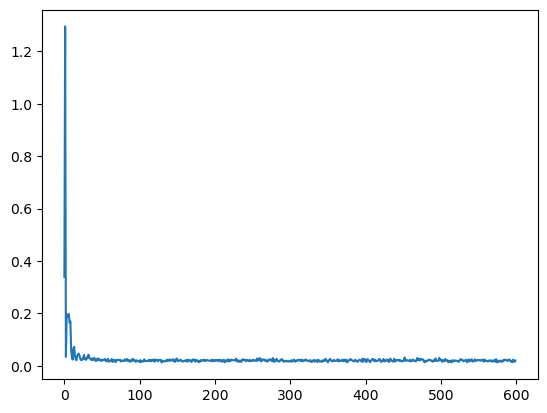

In [9]:
plt.plot(np.arange(len(ER_train_loss)), ER_train_loss)

In [10]:
regressor.eval()
cal_loader = torch.utils.data.DataLoader(dataset=cal_subset, shuffle=False, batch_size=len(cal_subset.indices))
for data, target in cal_loader:
    data, target = Variable(data), Variable(target)
    output = classifier(data)
    
Acal = 1 - output[np.arange(output.shape[0]), target]
Acal = Acal.detach().numpy()
AcalPredict = regressor(data).detach().numpy().flatten()

/var/folders/x8/908frjt170d_bfpfjzgp163r0000gn/T/ipykernel_85695/158888622.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x) # F.log_softmax(x)


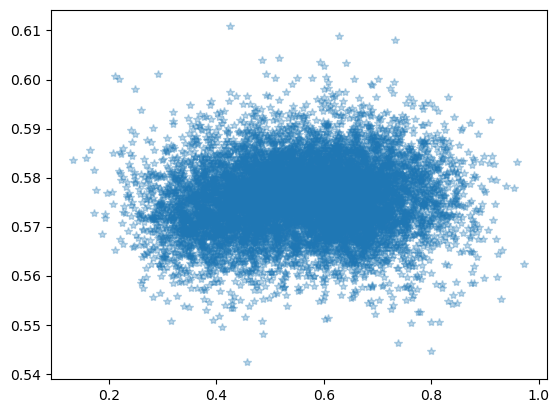

In [11]:
plt.plot(Acal, AcalPredict, '*', alpha = .3)

# Instead of a CNN regressor, use the MLP regressor instead

In [18]:
ER_train_loader = torch.utils.data.DataLoader(ER_train_data, shuffle=True, batch_size=len(ER))

for data, target in ER_train_loader:
    X = data.squeeze(1).reshape(len(ER), -1).detach().numpy()
    y = target.detach().numpy()
    
from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(15, 15))
regressor.fit(X, y)

/Users/lorry/anaconda3/envs/env_full/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=(15, 15), solver='lbfgs')

In [19]:
cal_loader = torch.utils.data.DataLoader(dataset=cal_subset, shuffle=False, batch_size=len(cal_subset.indices))
for data, target in cal_loader:
    X = data.squeeze(1).reshape(len(cal_subset.indices), -1).detach().numpy()
AcalPredict = regressor.predict(X)

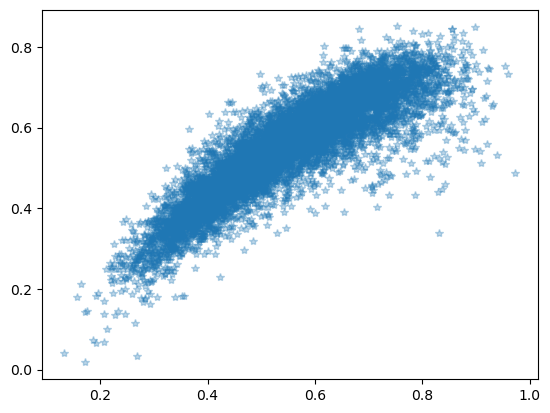

In [20]:
plt.plot(Acal, AcalPredict, '*', alpha = .3)

QA, QB 0.8469548 0.20618779699029866


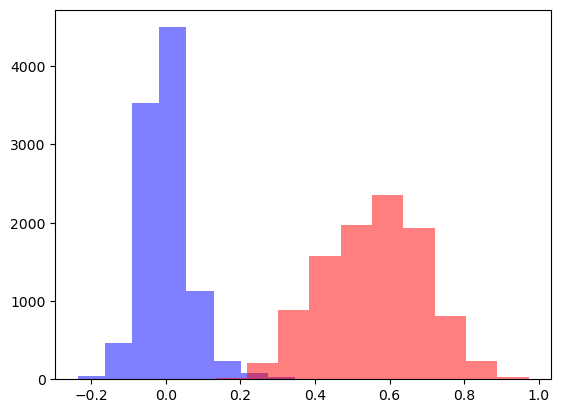

In [21]:
Bcal = Acal - AcalPredict
plt.hist(Bcal, alpha=.5, color='b')
plt.hist(Acal, alpha=.5, color='r')
alpha = .01
QB = np.sort(Bcal)[int(np.ceil((len(Bcal) + 1) * (1 - alpha)))]
QA = np.sort(Acal)[int(np.ceil((len(Acal) + 1) * (1 - alpha)))]
print("QA, QB", QA, QB)

/var/folders/x8/908frjt170d_bfpfjzgp163r0000gn/T/ipykernel_85695/158888622.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x) # F.log_softmax(x)


alpha, QA, QB, maxA, maxB 0.01 0.846361 0.20615396893373006 0.9732071 0.4922075214891771
alpha, QA, QB, maxA, maxB 0.05 0.7723597 0.11153285278387015 0.9732071 0.4922075214891771
alpha, QA, QB, maxA, maxB 0.09 0.73314005 0.07948037451954137 0.9732071 0.4922075214891771
alpha, QA, QB, maxA, maxB 0.13 0.70708853 0.061426405916406024 0.9732071 0.4922075214891771
alpha, QA, QB, maxA, maxB 0.17 0.6864327 0.04767854026126783 0.9732071 0.4922075214891771
alpha, QA, QB, maxA, maxB 0.21000000000000002 0.67007244 0.0374240740085634 0.9732071 0.4922075214891771
alpha, QA, QB, maxA, maxB 0.25 0.6553199 0.028797822447493626 0.9732071 0.4922075214891771
alpha, QA, QB, maxA, maxB 0.29000000000000004 0.64082456 0.022243698807184742 0.9732071 0.4922075214891771
alpha, QA, QB, maxA, maxB 0.33 0.62754357 0.015365751460689414 0.9732071 0.4922075214891771
alpha, QA, QB, maxA, maxB 0.37 0.61575186 0.009823403823918664 0.9732071 0.4922075214891771


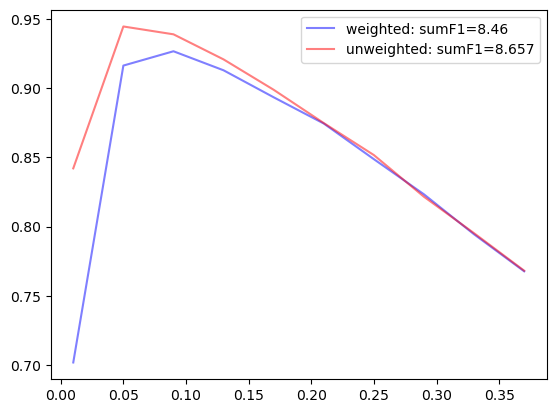

In [22]:
auc = [], []
tryAlpha = [0.01 + 0.04 * i for i in range(10)]

test_loader = torch.utils.data.DataLoader(dataset=test_subset, shuffle=False, batch_size=len(test_subset.indices))
for data, target in test_loader:
    data, target = Variable(data), Variable(target)
    output = classifier(data)
    
# AtestPredict = regressor(data).detach().numpy().flatten()
AtestPredict = regressor.predict(data.squeeze(1).reshape(len(test_subset.indices), -1).detach().numpy())
probsTest = output.detach().numpy()
y_test = target.detach().numpy()
Atest = np.array([[1 - probsTest[i][j] for j in range(len(probsTest[i]))] for i in range(len(probsTest))])
Btest = np.array([[1 - probsTest[i][j] - AtestPredict[i] for j in range(len(probsTest[i]))] for i in range(len(probsTest))]) 


for alpha in tryAlpha:#, 0.16, 0.32, 0.64, 0.9]:
    QB = np.sort(Bcal)[int(np.ceil((len(Bcal) + 1) * (1 - alpha)))-1]
    QA = np.sort(Acal)[int(np.ceil((len(Acal) + 1) * (1 - alpha)))-1]
    print("alpha, QA, QB, maxA, maxB", alpha, QA, QB, max(Acal), max(Bcal))
    
    intervalsA = [[j for j in range(len(probsTest[i])) if Atest[i][j] <= QA] for i in range(len(probsTest))]
    intervalsB = [[j for j in range(len(probsTest[i])) if Btest[i][j] <= QB] for i in range(len(probsTest))]

    TP, FP, TN, FN = [0, 0], [0, 0],[0, 0], [0, 0]
    intervalsAll = intervalsA, intervalsB
    for iModel in [0, 1]:
        for i in range(len(intervalsA)):
            intervals = intervalsAll[iModel][i]
            y = y_test[i]
            positives = [j for j in range(10) if j in intervals]
            TP[iModel] = TP[iModel] + sum([1 for j in positives if j == y])
            FP[iModel] = FP[iModel] + sum([1 for j in positives if j != y])
            negatives = [j for j in range(10) if j not in intervals]
            TN[iModel] = TN[iModel] + sum([1 for j in negatives if j != y])  
            FN[iModel] = FN[iModel] + sum([1 for j in negatives if j == y]) 
        F1 = 2 * TP[iModel]/(2 * TP[iModel] + FP[iModel] + FN[iModel])
        auc[iModel].append(F1)
s = [np.round(sum([x for x in auc[iModel]]), 3) for iModel in [0, 1]]

plt.plot(tryAlpha, [x for x in auc[1]], label='weighted: sumF1='+str(s[1]) ,alpha=0.5, color='b')
plt.plot(tryAlpha, [x for x in auc[0]], label='unweighted: sumF1='+str(s[0]) ,alpha=0.5, color='r')
plt.legend()


In [23]:
from collections import Counter
Counter([len(a) for a in intervalsA]), Counter([len(a) for a in intervalsB])

(Counter({1: 6256, 0: 3744}), Counter({1: 6311, 0: 3678, 2: 9, 4: 1, 3: 1}))